Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [1]:
import random
from random import choices, randint
import numpy as np
from copy import deepcopy
from heapq import heappush, heappop, heapify, heappushpop, nlargest
from tqdm.auto import tqdm
import time
import matplotlib.pyplot as plt

import lab9_lib

c:\Users\abdel\OneDrive\Desktop\Ingegneria matematica\Computational Intelligence\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# fitness = lab9_lib.make_problem(1)
# for n in range(10):
#     ind = choices([1, 1, 1, 1, 0], k=50)
#     print(f"{''.join(str(g) for g in ind)}: {fitness(ind):.2%}")

# print(fitness.calls)

Copyright **(c)** 2023 Abdelouahab Moubane <abdelmub@gmail.com>
https://github.com/AbdelouahabMoubane

In [3]:
"Xover not good"
def xover_bisection(votes_parent1, votes_parent2):
    """
    Function executing a simple crossover between 2 parents

    return: genome of the new individual
    """
    if not len(votes_parent1[1]) == len(votes_parent2[1]):
        print("Parent lenght must be the same")
        return None

    xover_point = len(votes_parent1[1]) // 2

    newborn = votes_parent1[1][:xover_point] + votes_parent2[1][xover_point:]
    return newborn

"Xover good"
def xover_bisection_weight(votes_parent1: tuple, votes_parent2: tuple):
    """
    Function executing a random crossover between 2 parents with weights that depends on fitness of parents or choosen manually

    return: genome of the new individual
    """
    if not len(votes_parent1[1]) == len(votes_parent2[1]):
        print("Parent lenght must be the same")
        return None 

    newborn = deepcopy(votes_parent2[1])
    #p=0.5
    p = votes_parent1[0]/(votes_parent1[0]+votes_parent2[0]+0.0000001)   
    for i in range(len(newborn)):
        if random.random() < p:
            newborn[i] = votes_parent1[1][i]            
     
    return newborn


def tournament(votes, tournament_size: int):
    """
    Function that choses a parent with tournament selection
    tournament_size: (int) size of the tournament
    return: index of the parent
    """
    candidates = [randint(0, len(votes)-1) for _ in range(tournament_size)]
    
    return candidates[np.argmax(votes[i][0] for i in candidates)]

def roulette(votes, size: int):
    """
    Function that choses a parent with roulette selection
    
    return: index of the parent
    """
    size=size #the line of code that does nothing, but shield from problems/warnings of not use the input size
              #so I can use it like tournament() in EA
    break_votes = zip(*votes)
    inverted_lists = [list(item) for item in break_votes]
    parent = random.choices(inverted_lists[1],inverted_lists[0])
    #parent = random.choices(inverted_lists[1],np.exp(inverted_lists[0]))
    index = [i for i, v in enumerate(votes) if v[1] == parent[0]]
    
    return index[0]

def random_change(parent,n):
    '''
    Genetic Operator that mutates a parent
    '''
    for i in range(n):
        index = randint(0, len(parent)-1)
        newborn = deepcopy(parent)
        newborn[index] = 1 - newborn[index]
    return newborn

def EA(
    mu: int,
    lamda: int,
    generations: int,
    fitness,
    mutation_func,
    xover_func,
    parent_selection_func,
    stop: int
):
    """
    Function execution a Genetic Algorithm
    mu: (int) is the population size
    lamda: (int) is the number of parent that are selected each generation
    generations: (int) is the number of generation that the algorithm will run
    fitness: function that evaluate the individual
    mutation_func: genetic operator that, given a single parent makes a mutation
    xover_func: genetic operator that, given 2 parents, makes an offspring
    parent_selection_func: selection of a parent
    stop: maximum number of generations without improvement, the code use different thresholds, 
          larger for difficult problems, I'm more patient in the problems 5 and 10
    """
    MUTATION_PROB = 0.1
    SELECTIVE_PRESSURE = 5
    # matrix where each row is an individual of the population
    #population = [choices([0, 1], k=1000) for _ in range(mu)]
    population = [random.choices([0, 1],[random.random()+0.01, random.random()+0.01], k=1000) for _ in range(mu)]
    # vector with fitness for each individual in the population
    population_fitness = [fitness(population[i]) for i in range(mu)]

    votes = list(zip(population_fitness, population))
    heapify(votes)

    time_mutation = 0
    time_xover = 0
    time_heap =0
    time_parent_selection = 0

    x = []

    for step in tqdm(range(generations)):
        for newborn in range(lamda):
            if random.random() < MUTATION_PROB:
                # do mutation
                # extract the index of the parent
                time_parent_selection_start = time.time()
                parent_index = parent_selection_func(
                    votes, SELECTIVE_PRESSURE
                )
                time_parent_selection_stop = time.time()
                time_parent_selection += time_parent_selection_stop - time_parent_selection_start
                # create a new offspring
                time_mutation_start = time.time()
                newborn = mutation_func(population[parent_index],10)
                time_mutation_stop = time.time()
                time_mutation += time_mutation_stop - time_mutation_start
                time_heap_start = time.time()
                heappushpop(votes, (fitness(newborn), newborn))
                time_heap_stop = time.time()
                time_heap += time_heap_stop - time_heap_start

            else:
                # 2 parents and xover
                time_parent_selection_start = time.time()
                parent_index1 = parent_selection_func(
                    votes, SELECTIVE_PRESSURE
                )
                parent_index2 = parent_selection_func(
                    votes, SELECTIVE_PRESSURE
                )
                time_parent_selection_stop = time.time()
                time_parent_selection += time_parent_selection_stop - time_parent_selection_start
                time_xover_start = time.time()
                newborn = xover_func(
                    votes[parent_index1], votes[parent_index2]
                )
                time_xover_stop = time.time()
                time_xover += time_xover_stop - time_xover_start
                time_heap_start = time.time()
                heappushpop(votes, (fitness(newborn), newborn))
                time_heap_stop = time.time()
                time_heap += time_heap_stop - time_heap_start

        x.append(nlargest(1, votes)[0][0]) 
        if x.count(x[step]) > stop or x[step] > 0.99:
            break       

    print("Time mutations: ", time_mutation)              
    print("Time parent selections: ",time_parent_selection)
    print("Time xovers: ",time_xover)
    print("Time heap: ", time_heap)
    
    plt.plot(x, marker='', linestyle='-', color='g')
    plt.ylim(0,1)
    plt.show()
    
    return max(votes)

  3%|▎         | 134/5000 [00:10<06:03, 13.39it/s]


Time mutations:  3.156470537185669
Time parent selections:  2.25838303565979
Time xovers:  3.7906394004821777
Time heap:  0.7070174217224121


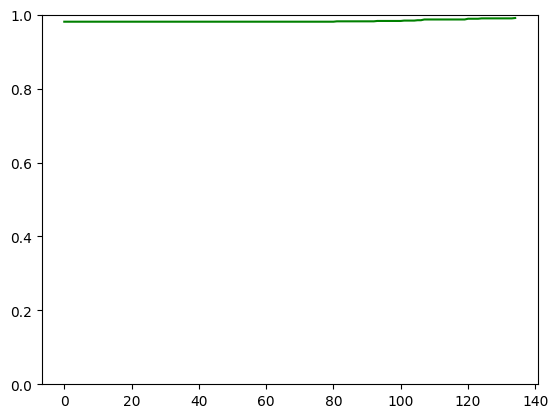

0.991 7250


In [4]:
fitness = lab9_lib.make_problem(1)

best = EA(500, 50, 5000, fitness, random_change, xover_bisection_weight, roulette, 100)
print(best[0], fitness.calls)

  4%|▍         | 211/5000 [00:15<05:55, 13.48it/s]


Time mutations:  5.271987438201904
Time parent selections:  3.2927989959716797
Time xovers:  5.7893147468566895
Time heap:  1.1396007537841797


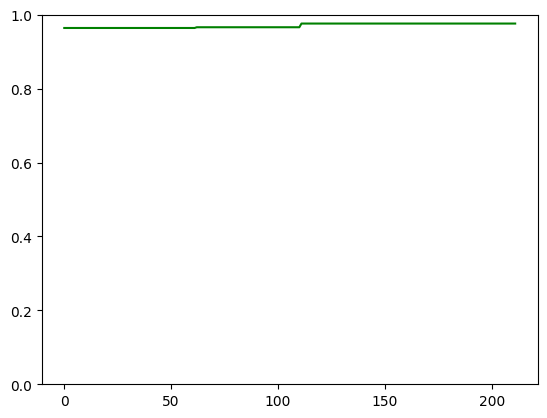

0.976 11100


In [5]:
fitness = lab9_lib.make_problem(2)

best = EA(500, 50, 5000, fitness, random_change, xover_bisection_weight, roulette, 100)
print(best[0], fitness.calls)

 11%|█         | 535/5000 [00:40<05:37, 13.23it/s]


Time mutations:  13.203701734542847
Time parent selections:  8.750098943710327
Time xovers:  15.173804759979248
Time heap:  2.8938941955566406


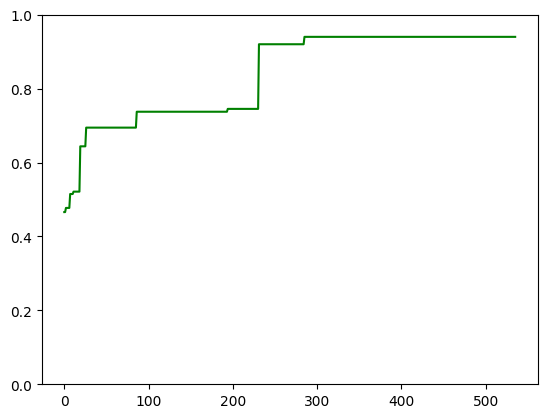

0.94 27300


In [22]:
fitness = lab9_lib.make_problem(5)

best = EA(500, 50, 5000, fitness, random_change, xover_bisection_weight, roulette, 250)
print(best[0], fitness.calls)

 14%|█▎        | 679/5000 [01:00<06:26, 11.19it/s]


Time mutations:  16.26291275024414
Time parent selections:  20.632774591445923
Time xovers:  18.877286672592163
Time heap:  4.282486438751221


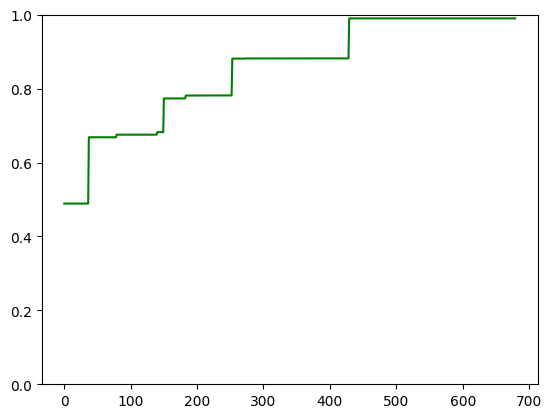

0.99 34500


In [21]:
fitness = lab9_lib.make_problem(10)

best = EA(500, 50, 5000, fitness, random_change, xover_bisection_weight, roulette, 250)
print(best[0], fitness.calls)
